# Code Perturbation using Gemma

This notebook analyzes the dataset, discards code snippets longer than 4096 tokens, and processes the entire dataset to create perturbations using a Gemma model by Google


In [1]:
# Local Model Setup for Code Modification
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


In [2]:
# Import required libraries
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.aigcodeset import AIGCodeSet
import logging
from datasets import concatenate_datasets
from Levenshtein import distance as Levenshtein_distance
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model_name = "google/gemma-2b-it"  # Using 2B for better performance on most hardware
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id


In [4]:
# Load dataset
train, val, test = AIGCodeSet(cache_dir='../../data').get_dataset(split=True)

In [5]:
# Concatenate and explore dataset
dataset = concatenate_datasets([train, val, test])
print(f"Total dataset size: {len(dataset)}")
print(f"First sample target: {dataset[0]['target']}")
print(f"First sample code length: {len(dataset[0]['code'])} characters")

Total dataset size: 7583
First sample target: 1
First sample code length: 229 characters


##### Place all code samples inside of prompt, tokenize and save the ones that exceed about half+headroom of the model's 8192 token output context window

In [6]:
prompt = '''<start_of_turn>user
Refine this Python code to be more concise and readable while preserving its exact functionality. The code's input and output behavior must remain unchanged, regardless of input types or structure. Ensure the refined code:
- Is valid Python with no syntax errors.
- Maintains the same logic and results as the original.
- Avoids introducing new dependencies or invalid assumptions (e.g., treating scalars as iterables).
Return only the refined code, no explanations or comments:

{code}
<end_of_turn>
<start_of_turn>model'''

In [7]:
sample_lengths = {}


for i, sample in enumerate(dataset['code']):
    input_text = prompt.format(code=sample)
    tokens = tokenizer(input_text, return_length=True)  
    sample_lengths[i] = tokens['length'][0]

In [8]:
list(sample_lengths.items())[:5]

[(0, 192), (1, 263), (2, 1131), (3, 193), (4, 232)]

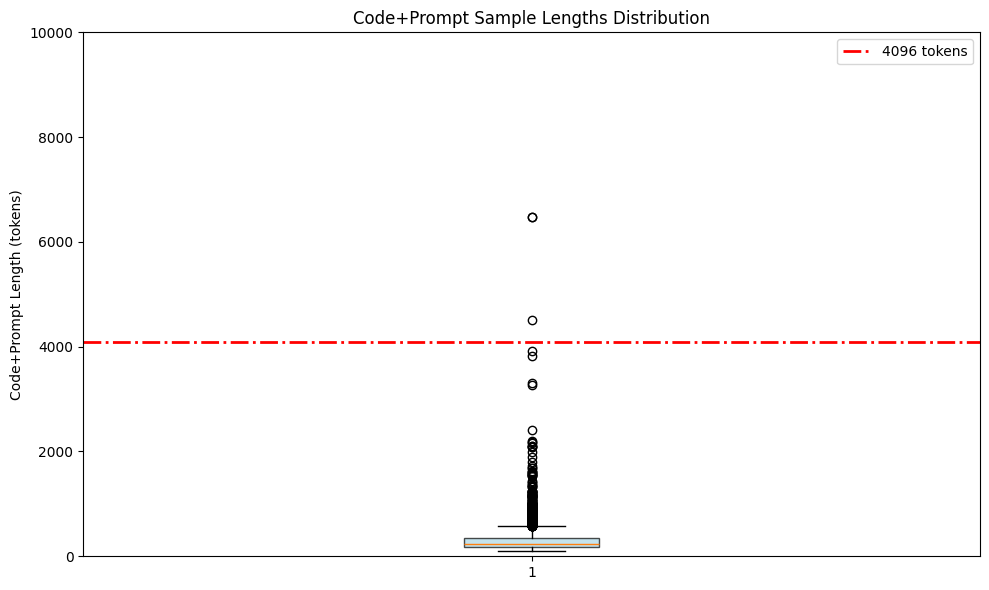

Total samples: 7,583
Samples above 4096 tokens: 3
Percentage above 4096: 0.04%
Max length: 6,479 tokens


In [9]:
# Simple analysis of sample lengths around 4096 characters
plt.figure(figsize=(10, 6))

# Calculate statistics
samples_above_4096 = sum(1 for s in sample_lengths.values() if s > 4096)
samples_3000_6000 = [s for s in sample_lengths if 3000 <= s <= 6000]

# Single focused plot
plt.boxplot(sample_lengths.values(), vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.ylabel('Code+Prompt Length (tokens)')
plt.title('Code+Prompt Sample Lengths Distribution')
plt.ylim(0, 10000)

# Add 4096 reference line
plt.axhline(4096, color='red', linestyle='-.', linewidth=2, label='4096 tokens')
plt.legend()

plt.tight_layout()
plt.show()

# Basic statistics
print(f"Total samples: {len(sample_lengths.values()):,}")
print(f"Samples above 4096 tokens: {samples_above_4096}")
print(f"Percentage above 4096: {samples_above_4096/len(sample_lengths.values())*100:.2f}%")
print(f"Max length: {max(sample_lengths.values()):,} tokens")


In [10]:
target = 4096
nearest_length = min(sample_lengths.values(), key=lambda x: abs(x - target))
nearest_distance = abs(nearest_length - target)

print(f"Sample length nearest to 4096: {nearest_length}")
print(f"Distance from 4096: {nearest_distance}")

nearest_index = [idx for idx, length in sample_lengths.items() if length == nearest_length][0]
print(f"Sample index with nearest length: {nearest_index}")

Sample length nearest to 4096: 3913
Distance from 4096: 183
Sample index with nearest length: 6589


In [11]:
dataset = dataset.filter(lambda example, idx: sample_lengths.get(idx, 0) <= 4096, with_indices=True)

In [12]:
len(dataset)

7580

In [13]:
# Configure quantization for memory efficiency
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("Quantization config ready for 4-bit loading")

Quantization config ready for 4-bit loading


In [14]:
model_name = "google/gemma-2b-it"  
print(f"Loading {model_name}...")
print("This may take a few minutes...")

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config=quant_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model.eval()
    
print("✅ Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")

model.eval()

Loading google/gemma-2b-it...
This may take a few minutes...


2025-06-25 20:23:32,638 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded successfully!
Model device: cuda:0


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [15]:
# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

In [16]:
# Test local model with one random sample
import random
import re

def clean_response(response):
    pattern = r'```python\n(.*?)\n```'
    match = re.search(pattern, response, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""  

random_index = random.randint(0, len(dataset))
test_sample = dataset[random_index]

print(f"Testing local model with random sample {random_index}")
print(f"Target: {test_sample['target']}")
print(f"Original code length: {len(test_sample['code'])} characters")
print("="*80)

try:
    # Prepare prompt for Gemma
    prompt = f'''<start_of_turn>user
Refine this Python code to be more concise and readable while preserving its exact functionality. The code’s input and output behavior must remain unchanged, regardless of input types or structure. Ensure the refined code:
- Is valid Python with no syntax errors.
- Maintains the same logic and results as the original.
- Avoids introducing new dependencies or invalid assumptions (e.g., treating scalars as iterables).
Output ONLY the refined Python code. Do NOT include explanations, comments, or any text other than the code itself:

{test_sample['code']}
<end_of_turn>
<start_of_turn>model'''
    
    # Tokenize
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=2048,
        truncation=True,
        padding=True,
        return_length = True,
    ).to(device)
    length = inputs['length'].item()
    del inputs['length']
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=2*length+100,  
            min_new_tokens=50,
            temperature=0.7,     
            top_p=0.9,           
            do_sample=True,        
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode only new tokens
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs[0][input_length:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    # Clean response
    # response = response.split('<end_of_turn>')[0].strip()
    
    # response = response.strip('```').lstrip('```python').strip()
    response = clean_response(response)
    # Calculate distance
    distance = Levenshtein_distance(response, test_sample['code'])
    
    print(f"✅ Local Model Test Successful!")
    print(f"Modified code length: {len(response)} characters")
    print(f"Length change: {len(response) - len(test_sample['code']):+d}")
    print(f"Levenshtein distance: {distance}")
    print(f"Distance/Length ratio: {distance/len(test_sample['code']):.3f}")
    
    print(f"\nOriginal code:")
    print("-" * 40)
    print(test_sample['code'])
    
    print(f"\nModified code:")
    print("-" * 40)
    print(response)
    
except Exception as e:
    print(f"❌ Local Model Test Failed: {str(e)}")

print("="*80)

Testing local model with random sample 3015
Target: 0
Original code length: 294 characters
✅ Local Model Test Successful!
Modified code length: 232 characters
Length change: -62
Levenshtein distance: 136
Distance/Length ratio: 0.463

Original code:
----------------------------------------
import sys
input = sys.stdin.readline
n=int(input())
a=list(map(int,input().split()))
cnt2=0
cnt4=0
for i in range(n):
    if a[i]%4==0:
        cnt4+=1
    elif a[i]%2==0:
        cnt2+=1
if cnt2>1:
    ans=len(a)-cnt4*3-cnt2
if cnt2==1:
    ans=len(a)-cnt4*3
print("Yes" if ans<=0 else "No")


Modified code:
----------------------------------------
import sys

n = int(input())
a = list(map(int, input().split()))

if sum(x % 4 for x in a) > 1:
    ans = len(a) - 3 * cnt4 - cnt2
elif cnt2 == 1:
    ans = len(a) - 3 * cnt4
else:
    ans = len(a)
print("Yes" if ans <= 0 else "No")


In [17]:
def save_results(path, data):
    try:
        with open(path, "w") as f:
            json.dump(data, f, indent=2)
    except Exception as e:
        print(f"Error saving results: {e}")

In [18]:
modified_samples = {}
levenshtein_distances = []

print("Processing entire dataset...")

prompt = '''<start_of_turn>user
Refine this Python code to be more concise and readable while preserving its exact functionality. The code’s input and output behavior must remain unchanged, regardless of input types or structure. Ensure the refined code:
- Is valid Python with no syntax errors.
- Maintains the same logic and results as the original.
- Avoids introducing new dependencies or invalid assumptions (e.g., treating scalars as iterables).
Output ONLY the refined Python code. Do NOT include explanations, comments, or any text other than the code itself:
{code}
<end_of_turn>
<start_of_turn>model'''

from torch.nn.utils.rnn import pad_sequence

def left_pad(sequences, pad_token_id):
    max_len = max(len(seq) for seq in sequences)
    padded = []
    for seq in sequences:
        pad_len = max_len - len(seq)
        padded.append(torch.cat([torch.full((pad_len,), pad_token_id, dtype=seq.dtype), seq]))
    return torch.stack(padded)

batch_size = 8
batch_inputs = []
batch_sample_ids = []
batch_codes = []
batch_targets = []

for i, sample in enumerate(tqdm(dataset, desc="Generating in batches")):
    input_text = prompt.format(code=sample['code'])
    tokenized = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=8192,
        truncation=True,
        padding=False  # manual padding
    )
    input_ids = tokenized['input_ids'][0]
    attention_mask = tokenized['attention_mask'][0]

    batch_inputs.append((input_ids, attention_mask))
    batch_sample_ids.append(i)
    batch_codes.append(sample['code'])
    batch_targets.append(sample['target'])

    if len(batch_inputs) == batch_size or i == len(dataset) - 1:
        input_ids_padded = left_pad([x[0] for x in batch_inputs], tokenizer.pad_token_id)
        attention_mask_padded = left_pad([x[1] for x in batch_inputs], 0)

        inputs = {
            "input_ids": input_ids_padded.to(device),
            "attention_mask": attention_mask_padded.to(device),
        }

        input_lengths = [len(x[0]) for x in batch_inputs]

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max(8192 + 50 - l for l in input_lengths),
                min_new_tokens=20,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        for j, (sample_idx, orig_code, target, input_len) in enumerate(zip(batch_sample_ids, batch_codes, batch_targets, input_lengths)):
            gen_tokens = outputs[j][input_len:]
            gen_text = tokenizer.decode(gen_tokens, skip_special_tokens=True)
            response = clean_response(gen_text)
            distance = Levenshtein_distance(response, orig_code)

            modified_samples[sample_idx] = {
                'original_code': orig_code,
                'modified_code': response,
                'target': target,
                'levenshtein_distance': distance,
                'original_length': len(orig_code),
                'modified_length': len(response),
                'dataset_index': sample_idx
            }

            levenshtein_distances.append(distance)

        # Clear batch
        batch_inputs = []
        batch_sample_ids = []
        batch_codes = []
        batch_targets = []

        if (i + 1) % 10 == 0:
            avg_distance = sum(levenshtein_distances) / len(levenshtein_distances)
            print(f"Processed {i+1}/{len(dataset)} samples. Avg. Levenshtein: {avg_distance:.2f}")

        if (i + 1) % 100 == 0:
            try:
                save_results("modified_samples_partial.json", modified_samples)
            except Exception as e:
                print(f"Error during partial save: {e}")


Processing entire dataset...


Generating in batches:   1%|          | 40/7580 [01:24<3:59:41,  1.91s/it]

Processed 40/7580 samples. Avg. Levenshtein: 300.65


Generating in batches:   1%|          | 80/7580 [02:08<2:39:26,  1.28s/it]

Processed 80/7580 samples. Avg. Levenshtein: 252.04


Generating in batches:   2%|▏         | 120/7580 [02:49<2:12:19,  1.06s/it]

Processed 120/7580 samples. Avg. Levenshtein: 231.22


Generating in batches:   2%|▏         | 160/7580 [03:31<2:08:16,  1.04s/it]

Processed 160/7580 samples. Avg. Levenshtein: 203.64


Generating in batches:   3%|▎         | 200/7580 [04:31<2:45:24,  1.34s/it]

Processed 200/7580 samples. Avg. Levenshtein: 192.22


Generating in batches:   3%|▎         | 240/7580 [05:17<2:19:38,  1.14s/it]

Processed 240/7580 samples. Avg. Levenshtein: 184.45


Generating in batches:   4%|▎         | 280/7580 [06:04<2:37:49,  1.30s/it]

Processed 280/7580 samples. Avg. Levenshtein: 185.97


Generating in batches:   4%|▍         | 320/7580 [07:04<2:48:26,  1.39s/it]

Processed 320/7580 samples. Avg. Levenshtein: 188.61


Generating in batches:   5%|▍         | 360/7580 [07:59<2:35:28,  1.29s/it]

Processed 360/7580 samples. Avg. Levenshtein: 189.38


Generating in batches:   5%|▌         | 400/7580 [09:52<3:58:42,  1.99s/it]

Processed 400/7580 samples. Avg. Levenshtein: 188.25


Generating in batches:   6%|▌         | 440/7580 [10:45<2:38:21,  1.33s/it]

Processed 440/7580 samples. Avg. Levenshtein: 187.21


Generating in batches:   6%|▋         | 480/7580 [11:44<3:07:22,  1.58s/it]

Processed 480/7580 samples. Avg. Levenshtein: 186.49


Generating in batches:   7%|▋         | 520/7580 [12:45<2:59:52,  1.53s/it]

Processed 520/7580 samples. Avg. Levenshtein: 186.02


Generating in batches:   7%|▋         | 560/7580 [13:49<3:05:15,  1.58s/it]

Processed 560/7580 samples. Avg. Levenshtein: 184.34


Generating in batches:   8%|▊         | 600/7580 [14:33<2:06:05,  1.08s/it]

Processed 600/7580 samples. Avg. Levenshtein: 185.35


Generating in batches:   8%|▊         | 640/7580 [16:10<4:07:24,  2.14s/it]

Processed 640/7580 samples. Avg. Levenshtein: 185.01


Generating in batches:   9%|▉         | 680/7580 [16:48<2:03:24,  1.07s/it]

Processed 680/7580 samples. Avg. Levenshtein: 182.38


Generating in batches:   9%|▉         | 720/7580 [18:06<4:28:27,  2.35s/it]

Processed 720/7580 samples. Avg. Levenshtein: 179.78


Generating in batches:  10%|█         | 760/7580 [20:21<4:05:13,  2.16s/it]

Processed 760/7580 samples. Avg. Levenshtein: 183.54


Generating in batches:  11%|█         | 800/7580 [21:07<2:22:36,  1.26s/it]

Processed 800/7580 samples. Avg. Levenshtein: 182.72


Generating in batches:  11%|█         | 840/7580 [22:18<3:26:53,  1.84s/it]

Processed 840/7580 samples. Avg. Levenshtein: 183.72


Generating in batches:  12%|█▏        | 880/7580 [23:02<2:17:55,  1.24s/it]

Processed 880/7580 samples. Avg. Levenshtein: 181.89


Generating in batches:  12%|█▏        | 920/7580 [24:27<2:58:36,  1.61s/it]

Processed 920/7580 samples. Avg. Levenshtein: 183.01


Generating in batches:  13%|█▎        | 960/7580 [25:18<2:18:25,  1.25s/it]

Processed 960/7580 samples. Avg. Levenshtein: 185.84


Generating in batches:  13%|█▎        | 1000/7580 [26:15<2:33:47,  1.40s/it]

Processed 1000/7580 samples. Avg. Levenshtein: 186.02


Generating in batches:  14%|█▎        | 1040/7580 [27:03<2:09:17,  1.19s/it]

Processed 1040/7580 samples. Avg. Levenshtein: 183.15


Generating in batches:  14%|█▍        | 1080/7580 [27:53<2:18:22,  1.28s/it]

Processed 1080/7580 samples. Avg. Levenshtein: 182.43


Generating in batches:  15%|█▍        | 1120/7580 [28:50<2:23:44,  1.33s/it]

Processed 1120/7580 samples. Avg. Levenshtein: 182.37


Generating in batches:  15%|█▌        | 1160/7580 [30:06<2:48:43,  1.58s/it]

Processed 1160/7580 samples. Avg. Levenshtein: 184.98


Generating in batches:  16%|█▌        | 1200/7580 [31:10<2:50:24,  1.60s/it]

Processed 1200/7580 samples. Avg. Levenshtein: 185.49


Generating in batches:  16%|█▋        | 1240/7580 [31:47<1:51:19,  1.05s/it]

Processed 1240/7580 samples. Avg. Levenshtein: 184.74


Generating in batches:  17%|█▋        | 1280/7580 [32:41<2:05:45,  1.20s/it]

Processed 1280/7580 samples. Avg. Levenshtein: 183.18


Generating in batches:  17%|█▋        | 1320/7580 [34:04<3:34:03,  2.05s/it]

Processed 1320/7580 samples. Avg. Levenshtein: 184.39


Generating in batches:  18%|█▊        | 1360/7580 [34:54<2:18:38,  1.34s/it]

Processed 1360/7580 samples. Avg. Levenshtein: 184.15


Generating in batches:  18%|█▊        | 1400/7580 [36:09<2:40:23,  1.56s/it]

Processed 1400/7580 samples. Avg. Levenshtein: 186.72


Generating in batches:  19%|█▉        | 1440/7580 [37:06<2:33:50,  1.50s/it]

Processed 1440/7580 samples. Avg. Levenshtein: 186.88


Generating in batches:  20%|█▉        | 1480/7580 [39:29<8:37:50,  5.09s/it]

Processed 1480/7580 samples. Avg. Levenshtein: 186.05


Generating in batches:  20%|██        | 1520/7580 [40:45<4:23:25,  2.61s/it]

Processed 1520/7580 samples. Avg. Levenshtein: 191.56


Generating in batches:  21%|██        | 1560/7580 [41:43<3:01:37,  1.81s/it]

Processed 1560/7580 samples. Avg. Levenshtein: 192.01


Generating in batches:  21%|██        | 1600/7580 [42:36<2:27:58,  1.48s/it]

Processed 1600/7580 samples. Avg. Levenshtein: 191.43


Generating in batches:  22%|██▏       | 1640/7580 [43:50<3:01:05,  1.83s/it]

Processed 1640/7580 samples. Avg. Levenshtein: 192.81


Generating in batches:  22%|██▏       | 1680/7580 [44:30<1:48:32,  1.10s/it]

Processed 1680/7580 samples. Avg. Levenshtein: 191.04


Generating in batches:  23%|██▎       | 1720/7580 [45:15<1:44:55,  1.07s/it]

Processed 1720/7580 samples. Avg. Levenshtein: 189.68


Generating in batches:  23%|██▎       | 1760/7580 [46:09<2:24:40,  1.49s/it]

Processed 1760/7580 samples. Avg. Levenshtein: 190.89


Generating in batches:  24%|██▎       | 1800/7580 [47:15<2:47:30,  1.74s/it]

Processed 1800/7580 samples. Avg. Levenshtein: 190.42


Generating in batches:  24%|██▍       | 1840/7580 [47:54<1:54:19,  1.20s/it]

Processed 1840/7580 samples. Avg. Levenshtein: 189.78


Generating in batches:  25%|██▍       | 1880/7580 [48:55<1:58:27,  1.25s/it]

Processed 1880/7580 samples. Avg. Levenshtein: 191.98


Generating in batches:  25%|██▌       | 1920/7580 [49:42<1:50:19,  1.17s/it]

Processed 1920/7580 samples. Avg. Levenshtein: 192.68


Generating in batches:  26%|██▌       | 1960/7580 [51:52<4:21:00,  2.79s/it]

Processed 1960/7580 samples. Avg. Levenshtein: 193.57


Generating in batches:  26%|██▋       | 2000/7580 [52:35<2:00:55,  1.30s/it]

Processed 2000/7580 samples. Avg. Levenshtein: 192.33


Generating in batches:  27%|██▋       | 2040/7580 [53:38<2:09:01,  1.40s/it]

Processed 2040/7580 samples. Avg. Levenshtein: 195.02


Generating in batches:  27%|██▋       | 2080/7580 [54:31<1:50:10,  1.20s/it]

Processed 2080/7580 samples. Avg. Levenshtein: 195.05


Generating in batches:  28%|██▊       | 2120/7580 [55:41<2:28:35,  1.63s/it]

Processed 2120/7580 samples. Avg. Levenshtein: 195.44


Generating in batches:  28%|██▊       | 2160/7580 [56:35<2:09:33,  1.43s/it]

Processed 2160/7580 samples. Avg. Levenshtein: 195.18


Generating in batches:  29%|██▉       | 2200/7580 [57:39<2:08:40,  1.44s/it]

Processed 2200/7580 samples. Avg. Levenshtein: 196.41


Generating in batches:  30%|██▉       | 2240/7580 [58:57<3:01:06,  2.03s/it]

Processed 2240/7580 samples. Avg. Levenshtein: 196.31


Generating in batches:  30%|███       | 2280/7580 [1:00:04<2:14:16,  1.52s/it]

Processed 2280/7580 samples. Avg. Levenshtein: 197.64


Generating in batches:  31%|███       | 2320/7580 [1:00:42<1:27:58,  1.00s/it]

Processed 2320/7580 samples. Avg. Levenshtein: 196.55


Generating in batches:  31%|███       | 2360/7580 [1:01:14<1:12:24,  1.20it/s]

Processed 2360/7580 samples. Avg. Levenshtein: 195.60


Generating in batches:  32%|███▏      | 2400/7580 [1:02:34<2:08:22,  1.49s/it]

Processed 2400/7580 samples. Avg. Levenshtein: 196.60


Generating in batches:  32%|███▏      | 2440/7580 [1:04:12<3:43:56,  2.61s/it]

Processed 2440/7580 samples. Avg. Levenshtein: 196.58


Generating in batches:  33%|███▎      | 2480/7580 [1:05:06<2:18:04,  1.62s/it]

Processed 2480/7580 samples. Avg. Levenshtein: 196.80


Generating in batches:  33%|███▎      | 2520/7580 [1:06:29<2:37:48,  1.87s/it]

Processed 2520/7580 samples. Avg. Levenshtein: 198.18


Generating in batches:  34%|███▍      | 2560/7580 [1:07:30<2:16:13,  1.63s/it]

Processed 2560/7580 samples. Avg. Levenshtein: 198.23


Generating in batches:  34%|███▍      | 2600/7580 [1:08:12<1:30:44,  1.09s/it]

Processed 2600/7580 samples. Avg. Levenshtein: 197.69


Generating in batches:  35%|███▍      | 2640/7580 [1:09:11<1:41:04,  1.23s/it]

Processed 2640/7580 samples. Avg. Levenshtein: 196.62


Generating in batches:  35%|███▌      | 2680/7580 [1:09:50<1:16:06,  1.07it/s]

Processed 2680/7580 samples. Avg. Levenshtein: 195.32


Generating in batches:  36%|███▌      | 2720/7580 [1:10:50<1:46:27,  1.31s/it]

Processed 2720/7580 samples. Avg. Levenshtein: 194.94


Generating in batches:  36%|███▋      | 2760/7580 [1:11:47<1:51:36,  1.39s/it]

Processed 2760/7580 samples. Avg. Levenshtein: 194.53


Generating in batches:  37%|███▋      | 2800/7580 [1:12:50<2:25:11,  1.82s/it]

Processed 2800/7580 samples. Avg. Levenshtein: 195.22


Generating in batches:  37%|███▋      | 2840/7580 [1:13:33<1:42:46,  1.30s/it]

Processed 2840/7580 samples. Avg. Levenshtein: 194.66


Generating in batches:  38%|███▊      | 2880/7580 [1:14:23<1:32:30,  1.18s/it]

Processed 2880/7580 samples. Avg. Levenshtein: 194.24


Generating in batches:  39%|███▊      | 2920/7580 [1:15:10<1:31:09,  1.17s/it]

Processed 2920/7580 samples. Avg. Levenshtein: 193.86


Generating in batches:  39%|███▉      | 2960/7580 [1:15:51<1:13:40,  1.05it/s]

Processed 2960/7580 samples. Avg. Levenshtein: 193.15


Generating in batches:  40%|███▉      | 3000/7580 [1:16:35<1:21:06,  1.06s/it]

Processed 3000/7580 samples. Avg. Levenshtein: 193.39


Generating in batches:  40%|████      | 3040/7580 [1:17:39<1:47:16,  1.42s/it]

Processed 3040/7580 samples. Avg. Levenshtein: 193.97


Generating in batches:  41%|████      | 3080/7580 [1:18:45<2:00:26,  1.61s/it]

Processed 3080/7580 samples. Avg. Levenshtein: 194.92


Generating in batches:  41%|████      | 3120/7580 [1:19:55<2:17:07,  1.84s/it]

Processed 3120/7580 samples. Avg. Levenshtein: 194.46


Generating in batches:  42%|████▏     | 3160/7580 [1:20:54<1:56:23,  1.58s/it]

Processed 3160/7580 samples. Avg. Levenshtein: 194.90


Generating in batches:  42%|████▏     | 3200/7580 [1:22:06<2:10:41,  1.79s/it]

Processed 3200/7580 samples. Avg. Levenshtein: 195.76


Generating in batches:  43%|████▎     | 3240/7580 [1:22:51<1:32:08,  1.27s/it]

Processed 3240/7580 samples. Avg. Levenshtein: 195.31


Generating in batches:  43%|████▎     | 3280/7580 [1:24:36<3:40:59,  3.08s/it]

Processed 3280/7580 samples. Avg. Levenshtein: 198.62


Generating in batches:  44%|████▍     | 3320/7580 [1:25:11<1:28:03,  1.24s/it]

Processed 3320/7580 samples. Avg. Levenshtein: 197.90


Generating in batches:  44%|████▍     | 3360/7580 [1:26:10<1:35:58,  1.36s/it]

Processed 3360/7580 samples. Avg. Levenshtein: 197.25


Generating in batches:  45%|████▍     | 3400/7580 [1:26:59<1:12:02,  1.03s/it]

Processed 3400/7580 samples. Avg. Levenshtein: 196.67


Generating in batches:  45%|████▌     | 3440/7580 [1:27:50<1:13:35,  1.07s/it]

Processed 3440/7580 samples. Avg. Levenshtein: 195.77


Generating in batches:  46%|████▌     | 3480/7580 [1:28:43<1:32:17,  1.35s/it]

Processed 3480/7580 samples. Avg. Levenshtein: 195.41


Generating in batches:  46%|████▋     | 3520/7580 [1:29:36<1:27:14,  1.29s/it]

Processed 3520/7580 samples. Avg. Levenshtein: 196.28


Generating in batches:  47%|████▋     | 3560/7580 [1:30:38<1:33:14,  1.39s/it]

Processed 3560/7580 samples. Avg. Levenshtein: 196.57


Generating in batches:  47%|████▋     | 3600/7580 [1:31:33<1:37:06,  1.46s/it]

Processed 3600/7580 samples. Avg. Levenshtein: 196.15


Generating in batches:  48%|████▊     | 3640/7580 [1:32:33<1:27:41,  1.34s/it]

Processed 3640/7580 samples. Avg. Levenshtein: 195.57


Generating in batches:  49%|████▊     | 3680/7580 [1:33:21<1:17:19,  1.19s/it]

Processed 3680/7580 samples. Avg. Levenshtein: 195.34


Generating in batches:  49%|████▉     | 3720/7580 [1:34:07<1:11:48,  1.12s/it]

Processed 3720/7580 samples. Avg. Levenshtein: 195.04


Generating in batches:  50%|████▉     | 3760/7580 [1:34:53<1:13:41,  1.16s/it]

Processed 3760/7580 samples. Avg. Levenshtein: 195.07


Generating in batches:  50%|█████     | 3800/7580 [1:36:00<1:43:24,  1.64s/it]

Processed 3800/7580 samples. Avg. Levenshtein: 195.36


Generating in batches:  51%|█████     | 3840/7580 [1:36:50<1:28:19,  1.42s/it]

Processed 3840/7580 samples. Avg. Levenshtein: 194.91


Generating in batches:  51%|█████     | 3880/7580 [1:37:35<1:15:47,  1.23s/it]

Processed 3880/7580 samples. Avg. Levenshtein: 194.76


Generating in batches:  52%|█████▏    | 3920/7580 [1:38:46<1:55:22,  1.89s/it]

Processed 3920/7580 samples. Avg. Levenshtein: 194.80


Generating in batches:  52%|█████▏    | 3960/7580 [1:39:50<1:33:53,  1.56s/it]

Processed 3960/7580 samples. Avg. Levenshtein: 194.68


Generating in batches:  53%|█████▎    | 4000/7580 [1:40:59<1:36:48,  1.62s/it]

Processed 4000/7580 samples. Avg. Levenshtein: 194.98


Generating in batches:  53%|█████▎    | 4040/7580 [1:42:33<2:59:47,  3.05s/it]

Processed 4040/7580 samples. Avg. Levenshtein: 194.90


Generating in batches:  54%|█████▍    | 4080/7580 [1:43:30<1:38:54,  1.70s/it]

Processed 4080/7580 samples. Avg. Levenshtein: 194.45


Generating in batches:  54%|█████▍    | 4120/7580 [1:44:22<1:15:34,  1.31s/it]

Processed 4120/7580 samples. Avg. Levenshtein: 193.92


Generating in batches:  55%|█████▍    | 4160/7580 [1:45:11<1:12:08,  1.27s/it]

Processed 4160/7580 samples. Avg. Levenshtein: 193.80


Generating in batches:  55%|█████▌    | 4200/7580 [1:45:47<57:01,  1.01s/it]  

Processed 4200/7580 samples. Avg. Levenshtein: 193.23


Generating in batches:  56%|█████▌    | 4240/7580 [1:46:55<1:40:16,  1.80s/it]

Processed 4240/7580 samples. Avg. Levenshtein: 193.69


Generating in batches:  56%|█████▋    | 4280/7580 [1:47:41<1:05:55,  1.20s/it]

Processed 4280/7580 samples. Avg. Levenshtein: 193.30


Generating in batches:  57%|█████▋    | 4320/7580 [1:49:15<1:40:43,  1.85s/it]

Processed 4320/7580 samples. Avg. Levenshtein: 193.32


Generating in batches:  58%|█████▊    | 4360/7580 [1:50:28<1:24:40,  1.58s/it]

Processed 4360/7580 samples. Avg. Levenshtein: 194.41


Generating in batches:  58%|█████▊    | 4400/7580 [1:52:49<3:12:05,  3.62s/it]

Processed 4400/7580 samples. Avg. Levenshtein: 194.03


Generating in batches:  59%|█████▊    | 4440/7580 [1:53:44<1:28:03,  1.68s/it]

Processed 4440/7580 samples. Avg. Levenshtein: 193.48


Generating in batches:  59%|█████▉    | 4480/7580 [1:54:41<1:20:23,  1.56s/it]

Processed 4480/7580 samples. Avg. Levenshtein: 193.45


Generating in batches:  60%|█████▉    | 4520/7580 [1:55:33<1:06:45,  1.31s/it]

Processed 4520/7580 samples. Avg. Levenshtein: 193.36


Generating in batches:  60%|██████    | 4560/7580 [1:56:17<55:37,  1.11s/it]  

Processed 4560/7580 samples. Avg. Levenshtein: 193.36


Generating in batches:  61%|██████    | 4600/7580 [1:57:23<1:10:55,  1.43s/it]

Processed 4600/7580 samples. Avg. Levenshtein: 193.16


Generating in batches:  61%|██████    | 4640/7580 [1:58:22<1:05:32,  1.34s/it]

Processed 4640/7580 samples. Avg. Levenshtein: 192.75


Generating in batches:  62%|██████▏   | 4680/7580 [1:59:05<50:31,  1.05s/it]  

Processed 4680/7580 samples. Avg. Levenshtein: 192.38


Generating in batches:  62%|██████▏   | 4720/7580 [2:00:04<57:47,  1.21s/it]  

Processed 4720/7580 samples. Avg. Levenshtein: 191.78


Generating in batches:  63%|██████▎   | 4760/7580 [2:00:53<54:57,  1.17s/it]  

Processed 4760/7580 samples. Avg. Levenshtein: 191.57


Generating in batches:  63%|██████▎   | 4800/7580 [2:01:43<1:02:08,  1.34s/it]

Processed 4800/7580 samples. Avg. Levenshtein: 191.34


Generating in batches:  64%|██████▍   | 4840/7580 [2:03:03<1:28:32,  1.94s/it]

Processed 4840/7580 samples. Avg. Levenshtein: 190.80


Generating in batches:  64%|██████▍   | 4880/7580 [2:03:48<54:16,  1.21s/it]  

Processed 4880/7580 samples. Avg. Levenshtein: 190.82


Generating in batches:  65%|██████▍   | 4920/7580 [2:04:41<57:16,  1.29s/it]  

Processed 4920/7580 samples. Avg. Levenshtein: 190.41


Generating in batches:  65%|██████▌   | 4960/7580 [2:07:42<2:05:46,  2.88s/it]

Processed 4960/7580 samples. Avg. Levenshtein: 190.06


Generating in batches:  66%|██████▌   | 5000/7580 [2:08:23<51:39,  1.20s/it]  

Processed 5000/7580 samples. Avg. Levenshtein: 189.81


Generating in batches:  66%|██████▋   | 5040/7580 [2:09:21<57:41,  1.36s/it]  

Processed 5040/7580 samples. Avg. Levenshtein: 189.21


Generating in batches:  67%|██████▋   | 5080/7580 [2:10:16<55:43,  1.34s/it]  

Processed 5080/7580 samples. Avg. Levenshtein: 188.62


Generating in batches:  68%|██████▊   | 5120/7580 [2:11:32<1:12:51,  1.78s/it]

Processed 5120/7580 samples. Avg. Levenshtein: 188.92


Generating in batches:  68%|██████▊   | 5160/7580 [2:12:54<1:46:45,  2.65s/it]

Processed 5160/7580 samples. Avg. Levenshtein: 188.57


Generating in batches:  69%|██████▊   | 5200/7580 [2:14:03<1:25:46,  2.16s/it]

Processed 5200/7580 samples. Avg. Levenshtein: 189.71


Generating in batches:  69%|██████▉   | 5240/7580 [2:14:55<55:46,  1.43s/it]  

Processed 5240/7580 samples. Avg. Levenshtein: 189.19


Generating in batches:  70%|██████▉   | 5280/7580 [2:15:56<54:36,  1.42s/it]  

Processed 5280/7580 samples. Avg. Levenshtein: 188.92


Generating in batches:  70%|███████   | 5320/7580 [2:16:43<43:16,  1.15s/it]

Processed 5320/7580 samples. Avg. Levenshtein: 188.36


Generating in batches:  71%|███████   | 5360/7580 [2:18:00<1:13:00,  1.97s/it]

Processed 5360/7580 samples. Avg. Levenshtein: 188.56


Generating in batches:  71%|███████   | 5400/7580 [2:19:22<1:26:09,  2.37s/it]

Processed 5400/7580 samples. Avg. Levenshtein: 189.51


Generating in batches:  72%|███████▏  | 5440/7580 [2:20:20<1:05:03,  1.82s/it]

Processed 5440/7580 samples. Avg. Levenshtein: 189.57


Generating in batches:  72%|███████▏  | 5480/7580 [2:21:09<43:09,  1.23s/it]  

Processed 5480/7580 samples. Avg. Levenshtein: 189.30


Generating in batches:  73%|███████▎  | 5520/7580 [2:22:03<44:52,  1.31s/it]

Processed 5520/7580 samples. Avg. Levenshtein: 189.38


Generating in batches:  73%|███████▎  | 5560/7580 [2:23:06<52:58,  1.57s/it]

Processed 5560/7580 samples. Avg. Levenshtein: 189.08


Generating in batches:  74%|███████▍  | 5600/7580 [2:23:49<41:26,  1.26s/it]

Processed 5600/7580 samples. Avg. Levenshtein: 188.71


Generating in batches:  74%|███████▍  | 5640/7580 [2:24:54<41:54,  1.30s/it]  

Processed 5640/7580 samples. Avg. Levenshtein: 188.96


Generating in batches:  75%|███████▍  | 5680/7580 [2:25:58<51:57,  1.64s/it]

Processed 5680/7580 samples. Avg. Levenshtein: 188.61


Generating in batches:  75%|███████▌  | 5720/7580 [2:28:31<1:11:44,  2.31s/it]

Processed 5720/7580 samples. Avg. Levenshtein: 188.93


Generating in batches:  76%|███████▌  | 5760/7580 [2:29:31<54:00,  1.78s/it]  

Processed 5760/7580 samples. Avg. Levenshtein: 188.86


Generating in batches:  77%|███████▋  | 5800/7580 [2:31:02<1:01:48,  2.08s/it]

Processed 5800/7580 samples. Avg. Levenshtein: 189.97


Generating in batches:  77%|███████▋  | 5840/7580 [2:32:01<42:29,  1.47s/it]  

Processed 5840/7580 samples. Avg. Levenshtein: 189.57


Generating in batches:  78%|███████▊  | 5880/7580 [2:32:40<32:32,  1.15s/it]

Processed 5880/7580 samples. Avg. Levenshtein: 189.24


Generating in batches:  78%|███████▊  | 5920/7580 [2:33:22<24:59,  1.11it/s]

Processed 5920/7580 samples. Avg. Levenshtein: 188.89


Generating in batches:  79%|███████▊  | 5960/7580 [2:34:13<29:32,  1.09s/it]

Processed 5960/7580 samples. Avg. Levenshtein: 188.64


Generating in batches:  79%|███████▉  | 6000/7580 [2:35:19<41:52,  1.59s/it]

Processed 6000/7580 samples. Avg. Levenshtein: 188.23


Generating in batches:  80%|███████▉  | 6040/7580 [2:36:11<33:55,  1.32s/it]

Processed 6040/7580 samples. Avg. Levenshtein: 187.68


Generating in batches:  80%|████████  | 6080/7580 [2:38:41<1:24:20,  3.37s/it]

Processed 6080/7580 samples. Avg. Levenshtein: 188.19


Generating in batches:  81%|████████  | 6120/7580 [2:40:28<1:11:51,  2.95s/it]

Processed 6120/7580 samples. Avg. Levenshtein: 188.39


Generating in batches:  81%|████████▏ | 6160/7580 [2:41:37<46:40,  1.97s/it]  

Processed 6160/7580 samples. Avg. Levenshtein: 188.31


Generating in batches:  82%|████████▏ | 6200/7580 [2:42:44<35:36,  1.55s/it]

Processed 6200/7580 samples. Avg. Levenshtein: 188.86


Generating in batches:  82%|████████▏ | 6240/7580 [2:44:33<40:59,  1.84s/it]  

Processed 6240/7580 samples. Avg. Levenshtein: 190.14


Generating in batches:  83%|████████▎ | 6280/7580 [2:45:58<43:53,  2.03s/it]  

Processed 6280/7580 samples. Avg. Levenshtein: 190.52


Generating in batches:  83%|████████▎ | 6320/7580 [2:46:50<28:56,  1.38s/it]

Processed 6320/7580 samples. Avg. Levenshtein: 190.53


Generating in batches:  84%|████████▍ | 6360/7580 [2:48:02<34:00,  1.67s/it]

Processed 6360/7580 samples. Avg. Levenshtein: 190.63


Generating in batches:  84%|████████▍ | 6400/7580 [2:48:57<29:11,  1.48s/it]

Processed 6400/7580 samples. Avg. Levenshtein: 190.69


Generating in batches:  85%|████████▍ | 6440/7580 [2:49:58<30:18,  1.59s/it]

Processed 6440/7580 samples. Avg. Levenshtein: 190.89


Generating in batches:  85%|████████▌ | 6480/7580 [2:50:58<31:28,  1.72s/it]

Processed 6480/7580 samples. Avg. Levenshtein: 190.77


Generating in batches:  86%|████████▌ | 6520/7580 [2:52:10<36:22,  2.06s/it]

Processed 6520/7580 samples. Avg. Levenshtein: 190.84


Generating in batches:  87%|████████▋ | 6560/7580 [2:53:03<24:47,  1.46s/it]

Processed 6560/7580 samples. Avg. Levenshtein: 190.43


Generating in batches:  87%|████████▋ | 6600/7580 [2:56:06<1:41:02,  6.19s/it]

Processed 6600/7580 samples. Avg. Levenshtein: 191.96


Generating in batches:  88%|████████▊ | 6640/7580 [2:58:20<47:38,  3.04s/it]  

Processed 6640/7580 samples. Avg. Levenshtein: 193.78


Generating in batches:  88%|████████▊ | 6680/7580 [2:59:29<30:00,  2.00s/it]

Processed 6680/7580 samples. Avg. Levenshtein: 193.77


Generating in batches:  89%|████████▊ | 6720/7580 [3:00:33<23:45,  1.66s/it]

Processed 6720/7580 samples. Avg. Levenshtein: 193.79


Generating in batches:  89%|████████▉ | 6760/7580 [3:01:28<19:50,  1.45s/it]

Processed 6760/7580 samples. Avg. Levenshtein: 193.69


Generating in batches:  90%|████████▉ | 6800/7580 [3:02:33<21:46,  1.68s/it]

Processed 6800/7580 samples. Avg. Levenshtein: 193.83


Generating in batches:  90%|█████████ | 6840/7580 [3:03:20<16:16,  1.32s/it]

Processed 6840/7580 samples. Avg. Levenshtein: 193.22


Generating in batches:  91%|█████████ | 6880/7580 [3:03:58<11:48,  1.01s/it]

Processed 6880/7580 samples. Avg. Levenshtein: 193.05


Generating in batches:  91%|█████████▏| 6920/7580 [3:05:05<16:41,  1.52s/it]

Processed 6920/7580 samples. Avg. Levenshtein: 193.54


Generating in batches:  92%|█████████▏| 6960/7580 [3:05:54<12:14,  1.18s/it]

Processed 6960/7580 samples. Avg. Levenshtein: 193.45


Generating in batches:  92%|█████████▏| 7000/7580 [3:06:49<13:44,  1.42s/it]

Processed 7000/7580 samples. Avg. Levenshtein: 193.35


Generating in batches:  93%|█████████▎| 7040/7580 [3:07:51<13:57,  1.55s/it]

Processed 7040/7580 samples. Avg. Levenshtein: 193.16


Generating in batches:  93%|█████████▎| 7080/7580 [3:09:25<16:15,  1.95s/it]

Processed 7080/7580 samples. Avg. Levenshtein: 193.02


Generating in batches:  94%|█████████▍| 7120/7580 [3:10:30<12:24,  1.62s/it]

Processed 7120/7580 samples. Avg. Levenshtein: 192.77


Generating in batches:  94%|█████████▍| 7160/7580 [3:11:50<16:04,  2.30s/it]

Processed 7160/7580 samples. Avg. Levenshtein: 193.26


Generating in batches:  95%|█████████▍| 7200/7580 [3:12:40<09:11,  1.45s/it]

Processed 7200/7580 samples. Avg. Levenshtein: 192.98


Generating in batches:  96%|█████████▌| 7240/7580 [3:13:17<04:58,  1.14it/s]

Processed 7240/7580 samples. Avg. Levenshtein: 192.59


Generating in batches:  96%|█████████▌| 7280/7580 [3:14:06<05:57,  1.19s/it]

Processed 7280/7580 samples. Avg. Levenshtein: 192.25


Generating in batches:  97%|█████████▋| 7320/7580 [3:15:02<05:32,  1.28s/it]

Processed 7320/7580 samples. Avg. Levenshtein: 192.36


Generating in batches:  97%|█████████▋| 7360/7580 [3:15:50<04:21,  1.19s/it]

Processed 7360/7580 samples. Avg. Levenshtein: 192.23


Generating in batches:  98%|█████████▊| 7400/7580 [3:17:11<05:17,  1.76s/it]

Processed 7400/7580 samples. Avg. Levenshtein: 192.28


Generating in batches:  98%|█████████▊| 7440/7580 [3:18:10<03:26,  1.47s/it]

Processed 7440/7580 samples. Avg. Levenshtein: 192.32


Generating in batches:  99%|█████████▊| 7480/7580 [3:18:57<02:06,  1.26s/it]

Processed 7480/7580 samples. Avg. Levenshtein: 191.96


Generating in batches:  99%|█████████▉| 7520/7580 [3:19:42<01:05,  1.09s/it]

Processed 7520/7580 samples. Avg. Levenshtein: 191.51


Generating in batches: 100%|█████████▉| 7560/7580 [3:20:53<00:29,  1.46s/it]

Processed 7560/7580 samples. Avg. Levenshtein: 191.92


Generating in batches: 100%|██████████| 7580/7580 [3:21:14<00:00,  1.59s/it]

Processed 7580/7580 samples. Avg. Levenshtein: 191.83


In [19]:
save_results("modified_samples_partial.json", modified_samples)